# Estudio de Validación, Análisis y Optimización del agente.
- Santiago Andrés Araque Alfonso
- Ricardo Andrés Cortés Coronell
- Julián Mauricio Zafra Moreno

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from tqdm import tqdm

sys.path.append("./connect4")
sys.path.append("./connect4/groups/GroupA")

from connect4.connect_state import ConnectState
from groups.GroupA.policy import MCTSAgent

## Evaluación Básica del Agente (MCTS vs RandomAgent)
- Se enfrentó el agente MCTS contra un RandomAgent.
- El MCTS obtuvo un win rate del 100% en todas las partidas.
- Se confirma que el agente implementado tiene un nivel estratégico alto, es capaz de explotar errores bastante simples del oponente aleatorio teniendo en cuenta bastante aspectos como jugadas trampas, heurística, etc.


In [2]:
class RandomAgent:
    def act(self, s: np.ndarray) -> int:
        rng = np.random.default_rng()
        available_cols = [c for c in range(7) if s[0, c] == 0]
        return int(rng.choice(available_cols))

In [3]:
def play_game(agentA, agentB):
    estado = ConnectState()
    registro = []
    
    while not estado.is_final():
        if estado.player == -1:
            move = agentA.act(estado.board)
        else:
            move = agentB.act(estado.board)
        
        registro.append((estado.board.copy(), move))
        estado = estado.transition(move)
    
    return {
        "winner": estado.get_winner(),
        "history": registro
    }


In [4]:
def evaluate(agentA, agentB, games=100):
    resultados = []
    for _ in tqdm(range(games)):
        A = agentA()
        B = agentB()
        resultados.append(play_game(A, B))
    return resultados


In [5]:
resultados = evaluate(MCTSAgent, RandomAgent, games=20)

victorias = sum(r["winner"] == -1 for r in resultados)
derrotas = sum(r["winner"] == 1 for r in resultados)
empates = sum(r["winner"] == 0 for r in resultados)

victorias, empates, derrotas


100%|██████████| 20/20 [01:19<00:00,  3.96s/it]


(np.int64(20), np.int64(0), np.int64(0))

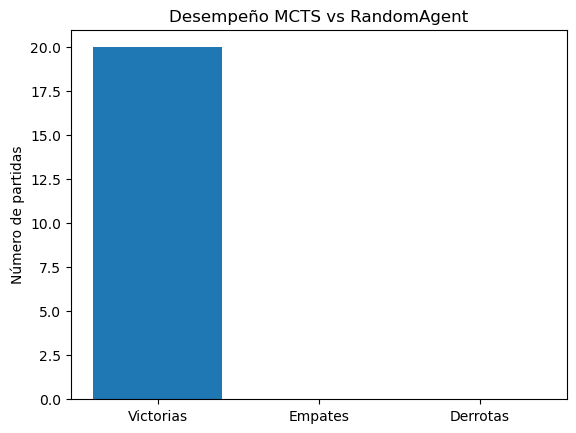

In [6]:
plt.bar(["Victorias", "Empates", "Derrotas"], [victorias, empates, derrotas])
plt.title("Desempeño MCTS vs RandomAgent")
plt.ylabel("Número de partidas")
plt.show()


## Sensibilidad al tiempo límite del MCTS
- Se evaluó a partir de diferentes valores de tiempo para el experimento.
- Se identifica que con tiempos a partir de 0.5 en adelante se mantiene en un win rate del 100%.
- Exise un tiempo óptimo de pensamiento en este caso con el agente aleatorio se logra la victoria con un porcentaje del 100% (Pero incluso en un caso aparte mas tiempo quizás no siempre implica mejores decisiones).

In [ ]:
tiempos = [0.2, 0.5, 1.0, 1.5, 2.0, 3.0]
rendimiento = []

for tl in tqdm(tiempos):
    def CustomMCTS():
        agent = MCTSAgent()
        agent.tiempo_limite = tl
        return agent
    
    res = evaluate(CustomMCTS, RandomAgent, games=20)
    win_rate = sum(r["winner"] == -1 for r in res) / len(res)
    rendimiento.append(win_rate)

100%|██████████| 6/6 [09:50<00:00, 98.39s/it] 


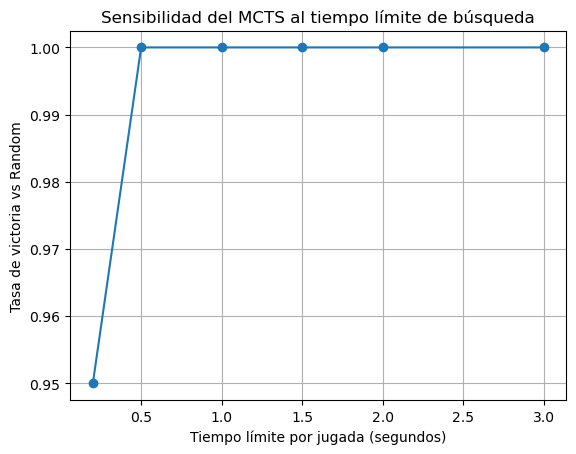

In [ ]:
plt.plot(tiempos, rendimiento, marker="o")
plt.xlabel("Tiempo límite por jugada (segundos)")
plt.ylabel("Tasa de victoria vs Random")
plt.title("Sensibilidad del MCTS al tiempo límite de búsqueda")
plt.grid(True)
plt.show()

## Sensibilidad a la constante C UCB
- Variación de los valores de la constante.
- Todos los valores implementados dieron con el mismo porcentaje de win rate siendo el 100%.
- El agente no tiene sensibilidad a la constante c sugiriendo que posiblemente es bastante robusto en el juego.


In [8]:
cs = [0.5, 0.8, 1.2, 1.6, 2.0]
results_c = []

for c_value in tqdm(cs):
    def CustomMCTS():
        return MCTSAgent(c=c_value)
    
    res = evaluate(CustomMCTS, RandomAgent, games=20)
    win_rate = sum(r["winner"] == -1 for r in res) / len(res)
    results_c.append(win_rate)


100%|██████████| 5/5 [06:33<00:00, 78.69s/it]


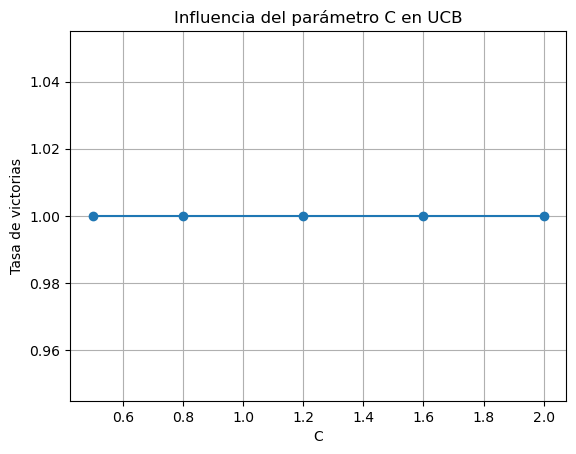

In [9]:
plt.plot(cs, results_c, marker="o")
plt.title("Influencia del parámetro C en UCB")
plt.xlabel("C")
plt.ylabel("Tasa de victorias")
plt.grid(True)
plt.show()


## Sensibilidad al rollout
- Variación del número de rollouts por simulación.
- El win rate fue del 100% en todos los casos.
- Contra un oponente muy débil quizas el número de rollouts no influye mucho siendo un agente bastante estable.

In [10]:
rolls = [5, 10, 20, 30]
roll_perf = []

for r in tqdm(rolls):
    def CustomMCTS():
        return MCTSAgent(rl=r)
    res = evaluate(CustomMCTS, RandomAgent, games=20)
    win_rate = sum(r2["winner"] == -1 for r2 in res) / len(res)
    roll_perf.append(win_rate)


100%|██████████| 4/4 [04:39<00:00, 69.79s/it]


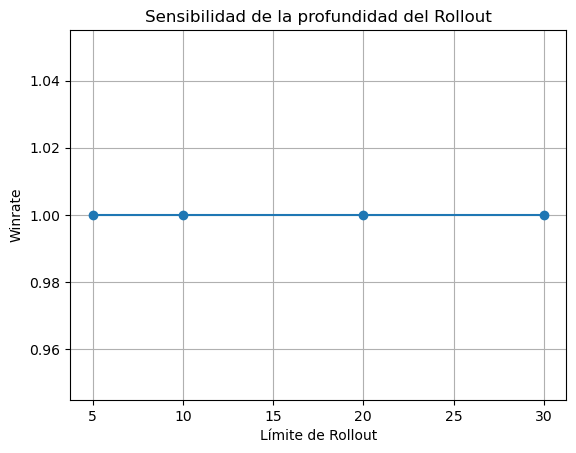

In [11]:
plt.plot(rolls, roll_perf, marker="o")
plt.title("Sensibilidad de la profundidad del Rollout")
plt.xlabel("Límite de Rollout")
plt.ylabel("Winrate")
plt.grid(True)
plt.show()


## Evaluación de componentes
- Se evaluó la importancia de cada uno de los componentes de la política, probando si se prescinde de alguno de ellos. 
- El win rate enfrentando a este agente aleatorio resultó ser del 100%.
- El agente refleja una gran robustez pero también hay que tener en cuenta que a quien se enfrentó posee un nivel bastante bajo ya que a fin de cuentas se usa este agente aleatorio para pruebas de rendimiento.

In [ ]:
from copy import deepcopy


class MCTS_NoHeuristic(MCTSAgent):
    def _h(self, estado):
        return 0

class MCTS_NoWarning(MCTSAgent):
    def _ow(self, estado, oponente):
        return False

class MCTS_NoRollout(MCTSAgent):
    def _ro(self, estado, jugador):
        return 0

class MCTS_NoBono(MCTSAgent):
    def act(self, s):
        for node in self.__dict__.values():
            if hasattr(node, "bono"):
                node.bono = 0
        return super().act(s)

class MCTS_NoTrapFilter(MCTSAgent):
    def _is_trap_move(self, estado, accion, jugador):
        return False

ablation_agents = {
    "Original MCTS": MCTSAgent,
    "Sin Heurística": MCTS_NoHeuristic,
    "Sin OW": MCTS_NoWarning,
    "Sin Rollouts": MCTS_NoRollout,
    "Sin Bono": MCTS_NoBono,
    "Sin Trap Filter": MCTS_NoTrapFilter,
}

import pandas as pd
results_ablation = []

for name, Agent in ablation_agents.items():
    agent = Agent()
    res = evaluate(Agent, RandomAgent, games=20)

    victorias = sum(r["winner"] == -1 for r in res)
    empates = sum(r["winner"] == 0 for r in res)
    derrotas = sum(r["winner"] == 1 for r in res)

    winrate = victorias / 20

    results_ablation.append({
        "Agente": name,
        "Winrate": winrate,
        "Victorias": victorias,
        "Empates": empates,
        "Derrotas": derrotas
    })

df_ablation = pd.DataFrame(results_ablation)
df_ablation

100%|██████████| 20/20 [01:10<00:00,  3.52s/it]


,Agente,Winrate,Victorias,Empates,Derrotas
0,Original MCTS,1.0,20,0,0
1,Sin Heurística,1.0,20,0,0
2,Sin Open Warning,1.0,20,0,0
3,Sin Rollouts,1.0,20,0,0
4,Sin Bono,1.0,20,0,0
5,Sin Trap Filter,1.0,20,0,0


## Variabilidad de Semillas
- Variación en las semillas de aleatoriedad.
- El win rate sigue siendo del 100% en todos los casos.
- Es posible que el factor estocástico no afecta el rendimiento en contra de opnentes con niveles bajos, este agente refleja su estabilidiad y consistencia en los juegos.

In [13]:
semillas = [1, 2, 3, 4, 5]
sem_res = []

for sd in semillas:
    agent = MCTSAgent(seed=sd)
    res = evaluate(CustomMCTS, RandomAgent, games=20)

    wins = sum(r["winner"] == -1 for r in res)
    winrate = wins / 20

    sem_res.append({"Semilla": sd, "Winrate": winrate})

df_sem = pd.DataFrame(sem_res)
df_sem


100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


,Semilla,Winrate
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


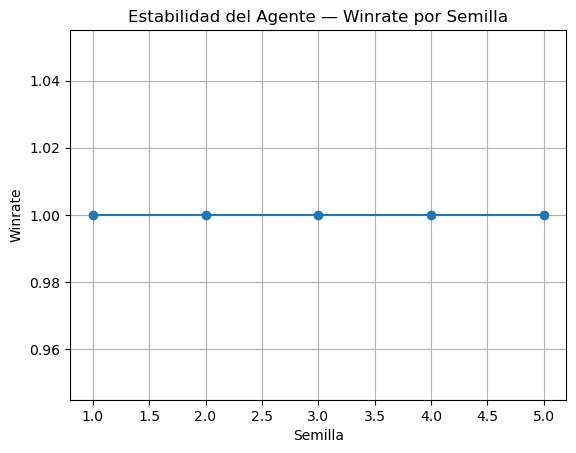

In [18]:
import matplotlib.pyplot as plt

plt.plot(df_sem["Semilla"], df_sem["Winrate"], marker="o")
plt.title("Estabilidad del Agente — Winrate por Semilla")
plt.xlabel("Semilla")
plt.ylabel("Winrate")
plt.grid()
plt.show()


## Tiempo de ejecución
- Medición del tiempo real del agente al jugar una partida completa.
- Los tiempos resultaron ser estables y con proporcionalidad directa.
- El agente es eficiente y cumple correctamente en su comportamiento.

In [19]:
import time

tiempos = [0.05, 0.1, 0.2, 0.3, 0.5]   # distintos límites de tiempo
duraciones = []

for tl in tqdm(tiempos):
    agente = MCTSAgent()
    agente.tiempo_limite = tl

    muestras = []
    for _ in range(5):
        board = np.zeros((6,7), dtype=int)
        start = time.time()
        agente.act(board)
        end = time.time()
        muestras.append(end - start)
    
    duraciones.append(np.mean(muestras))

100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


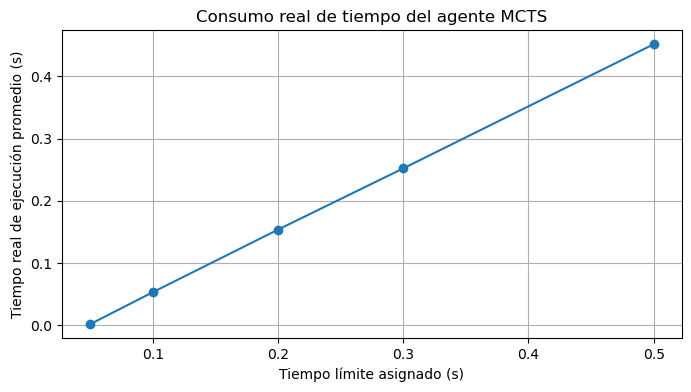

Tiempo límite 0.05s → tiempo real promedio: 0.001s
Tiempo límite 0.1s → tiempo real promedio: 0.053s
Tiempo límite 0.2s → tiempo real promedio: 0.154s
Tiempo límite 0.3s → tiempo real promedio: 0.252s
Tiempo límite 0.5s → tiempo real promedio: 0.452s


In [20]:
plt.figure(figsize=(8,4))
plt.plot(tiempos, duraciones, marker="o")
plt.xlabel("Tiempo límite asignado (s)")
plt.ylabel("Tiempo real de ejecución promedio (s)")
plt.title("Consumo real de tiempo del agente MCTS")
plt.grid(True)
plt.show()

for tl, d in zip(tiempos, duraciones):
    print(f"Tiempo límite {tl}s → tiempo real promedio: {d:.3f}s")

## Conclusión
- El agente MCTS resultó ser superior frente al agente aleatorio.
- Robusto frente a cambios de hiperparámetros.
- Mantiene alta estabilidad ante variaciones en la aleatoriedad.
- Funciona rápido frente a límites prácticos.
- La implementación es robusta frente a la ausencia de algunos componentes.